# Demo 3: Beatles lyrics

In this demo we will train a decoder-only transformer to generate lyrics in the style of The Beatles.
We will do this by training it on a corpus consisting of Beatles lyrics.

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch.utils.data import DataLoader

# set to true if working in google colab
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/Projects/Transformer'
    sys.path.append(root_dir)
else:
    root_dir = os.getcwd()

# custom imports
from transformer import layers
from transformer.layers import Transformer
from transformer.nlp import Vocab, TokenizedDataset, InferenceSampler

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device is {device}')

We use the custom Vocab class to load the text corpus and initialize the vocabulary according to this corpus. We will utilize a subword tokenization scheme in which we split the corpus at boundaries between word and non-word characters. The Vocab class provides useful methods for converting strings to tokens and vice versa. 

In [20]:
filepath = os.path.join(root_dir, 'data', 'short.txt')

# pattern matching boundary between word and non-word characters
pattern = r'\b'

vocab = Vocab(filepath, pattern)

We can now use the vocab to tokenize the corpus, using the method `tokenize_from_file`:

In [21]:
corpus = vocab.tokenize_from_file(filepath)  # list
corpus = torch.tensor(corpus, dtype=torch.long, device=device)  # tensor

print(f'Length of corpus: {len(corpus)} tokens')

Length of corpus: 151 tokens


Let's split our corpus so that 95% goes into the training set and 5% into the test set. We use the custom class TokenizedDataset to define the dataset. This class creates training examples consisting of (input, target) pairs, where input is the same token sequence as target but right shifted by one position.

In [22]:
context_window = 4
batch_size = 52

train_corpus = corpus[:round(0.95 * len(corpus))]
test_corpus = corpus[round(0.95 * len(corpus)):]


train_set = TokenizedDataset(train_corpus, context_window, device)
test_set = TokenizedDataset(test_corpus, context_window, device)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True)

print(f'Train loader: {len(train_loader)} batches of size {batch_size}')
print(f'Test loader: {len(test_loader)} batches of size {batch_size}')

Train loader: 3 batches of size 52
Test loader: 1 batches of size 52


Next we define the decoder-only transformer. It consists of the following layers:
- embedding and positional encoding
- decoder stack
- linear (de-embedding) layer
- softmax

Each decoder in the decoder stack consists of a masked multihead attention layer followed by a position-wise fully connected two-layer feed forward neural network.

In [43]:
model = Transformer(
    vocab=len(vocab),
    n_pe=10000,
    d_model=32,
    num_heads=8,
    num_stacks=1,
    d_ff=32 * 4,
    dropout=0.1
).to(device)

Let's see how the untrained model performs. To do this we first define an InferenceSampler object using the model and vocab. The custom InferenceSampler class provides methods for autoregressively generating outputs given a prompt, according to different sampling strategies.

In [ ]:
sampler = InferenceSampler(model, vocab, context_window, device)

The sampler allows for three sampling methods: greedy sampling, top_p sampling, and beam search. For example, greedy sampling simply outputs the most next token, given the previous tokens. Let's consider the input prompt 'You and me baby'. Greedy sampling gives the following output:

In [ ]:
prompt = 'You and me baby'
output = sampler.greedy(prompt)
print(output)

Unsurprisingly the untrained transformer's output doesn't make any sense. 

Now let's define the testing and training loops. We will use a cross entropy loss function and an Adam optimizer.

In [44]:
cost_fn = layers.CrossEntropyLoss(swap_dims=True)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)

def test(model, batches):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        batch = 0
        for input, target in test_loader:
            if batch >= batches: break
            output = model(input)
            total_loss += cost_fn(output, target)
            batch += 1

    model.train()

    # return average loss
    return total_loss.item() / batches

def train(model):

    train_losses = []
    test_losses = []

    batch = 0
    loss = float('inf')

    def save(model, batch):
        path = os.path.join(root_dir, 'checkpoints', f'batch{batch}.pt')
        torch.save(model.state_dict(), path)

    while True:

        for input, target in train_loader:

            if loss < 0.5: 
                save(model, batch)
                return train_losses, test_losses

            # output
            output = model(input)

            # loss
            loss = cost_fn(output, target)
            train_losses.append((batch, loss.item()))

            # backprop
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            # step
            optim.step()

            # test 
            if batch % 10 == 0:
                test_loss = test(model, 1)
                test_losses.append((batch, test_loss))

            # save checkpoint
            if batch % 50 == 0:
                save(model, batch)
            
            # print progress
            clear_output(wait=True)
            print(f'Batch {batch}: Loss = {loss.item():.3}')

            batch += 1

train_losses, test_losses = train(model)

Batch 1146: Loss = 0.498


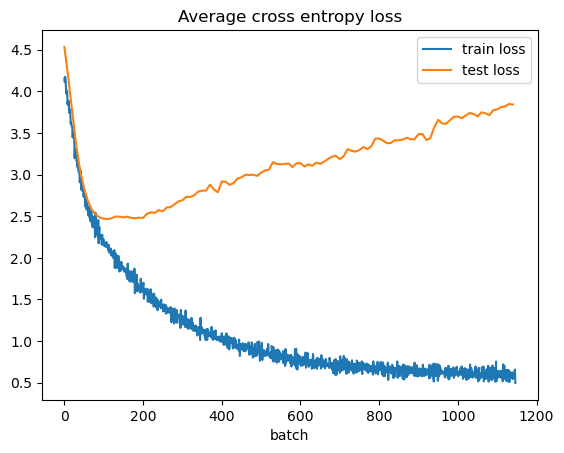

In [45]:
fig, ax = plt.subplots()

# train loss
x, y = zip(*train_losses)
ax.plot(x, y, label='train loss')

# test loss
x, y = zip(*test_losses)
ax.plot(x, y, label='test loss')

ax.set_xlabel('batch')
ax.set_title('Average cross entropy loss')
ax.legend()
plt.show()

In [ ]:
prompt = 'You'
output = sampler.greedy(prompt)
print(output)

In [ ]:
output = sampler.beam_search(prompt, 10)
print(output)